Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

Importar Dados

In [2]:
dfUdemy = pd.read_csv('udemy_courses.csv')

In [3]:
dfUdemy.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hours,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39 hours,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5 hours,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3 hours,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2 hours,2016-12-13T14:57:18Z,Business Finance


Limpar coluna URL

In [4]:
dfUdemy['clean_url'] = dfUdemy['url'].str.replace('https://www.udemy.com/','')
dfUdemy['clean_url'] = dfUdemy['clean_url'].str.replace('/','')
dfUdemy['clean_url'] = dfUdemy['clean_url'].str.replace('-',' ')

Criar coluna juntando as colunas 'Course Title' e 'Clean Url'

In [5]:
dfUdemy['course_url'] = dfUdemy['course_title'] + ' ' + dfUdemy['clean_url']

Criar novo DataFrame apenas com as colunas necessárias para analise

In [6]:
dfCursos = dfUdemy[['course_title', 'url', 'course_url', 'subject']]

In [7]:
dfCursos.describe()

,course_title,url,course_url,subject
count,3683,3683,3683,3683
unique,3668,3677,3677,4
top,Acoustic Blues Guitar Lessons,https://www.udemy.com/essentials-of-money-value/,Essentials of money value: Get a financial Lif...,Web Development
freq,3,2,2,1200


Função para limpar campos

In [8]:
def clean_text(text):
    # remove barra invertida-apóstrofo
    text = re.sub("\'", "", text)
    # remove tudo, exceto alfabetos
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove os espaços em branco
    text = ' '.join(text.split())
    # converter texto em minúsculas
    text = text.lower()
    
    return text

Aplica a função de limpar o campo na coluna 'Course Url'

In [9]:
dfCursos['clean_course'] = dfCursos['course_url'].apply(lambda x: clean_text(x))

<ipython-input-9-16e82389d1f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCursos['clean_course'] = dfCursos['course_url'].apply(lambda x: clean_text(x))


In [10]:
dfCursos.head()

,course_title,url,course_url,subject,clean_course
0,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,Ultimate Investment Banking Course ultimate in...,Business Finance,ultimate investment banking course ultimate in...
1,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,Complete GST Course & Certification - Grow You...,Business Finance,complete gst course certification grow your ca...
2,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,Financial Modeling for Business Analysts and C...,Business Finance,financial modeling for business analysts and c...
3,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,Beginner to Pro - Financial Analysis in Excel ...,Business Finance,beginner to pro financial analysis in excel co...
4,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,How To Maximize Your Profits Trading Options h...,Business Finance,how to maximize your profits trading options h...


Visualizar os valores únicos da coluna 'Subject'

In [11]:
dfCursos['subject'].unique()

array(['Business Finance', 'Graphic Design', 'Musical Instruments',
       'Web Development'], dtype=object)

Contar a frequencia da coluna 'Subject'

In [12]:
dfCursos['subject'].value_counts()

Web Development        1200
Business Finance       1199
Musical Instruments     681
Graphic Design          603
Name: subject, dtype: int64

Função para contar a frequencia de cada palavra em determinada coluna

In [13]:
def freq_words(x, s, terms = 30):
    if s == False:
        all_words = [text for text in x]
    else:
        all_words = ' '.join([text for text in x])
        all_words = all_words.split()
  
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x= "count", y = "word")
    ax.set(ylabel = 'Word')
    plt.show()

Plotar no gráfico a frequencia de cada 'Subject'

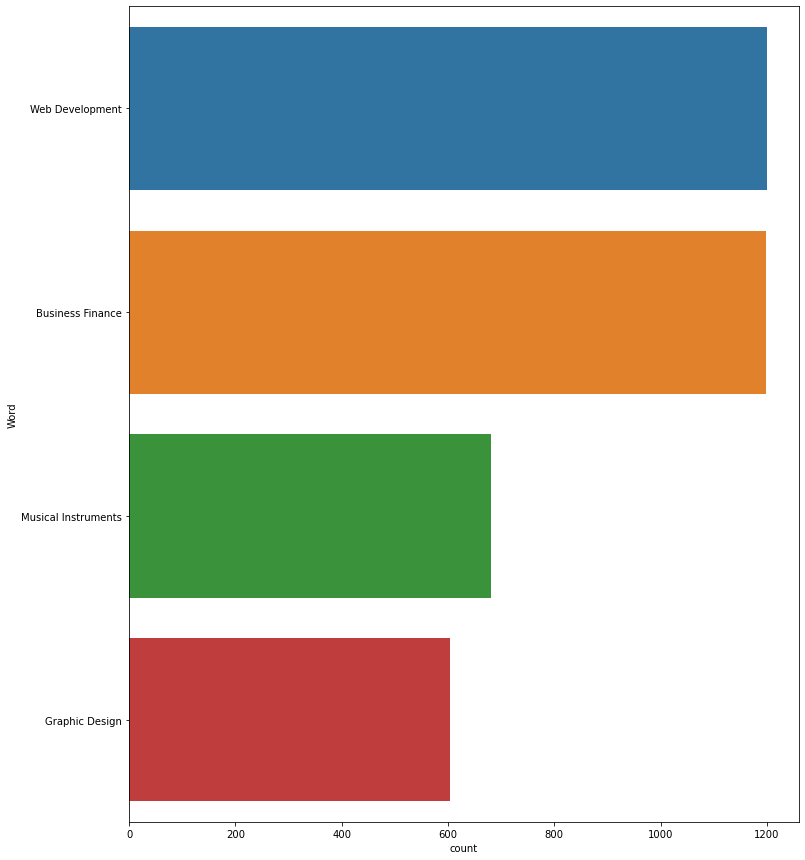

In [14]:
freq_words(dfCursos['subject'], False)

Plotar no gráfico as 100 palavras mais frequentes do campo 'Clean Course'

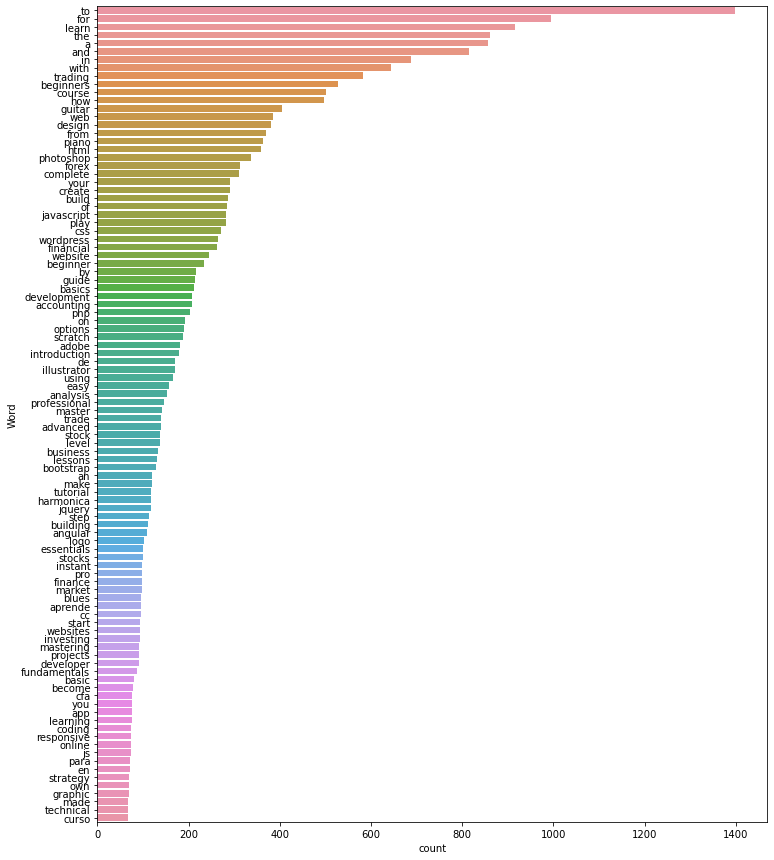

In [15]:
# print 100 most frequent words
freq_words(dfCursos['clean_course'], True, 100)

Download do pacote de palavras irrelevantes da biblioteca NLTK

In [16]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\00203885\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Função para remover as palavras irrelevantes

In [17]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

Removendo as palavras irrelevantes da coluna 'Clean Course'

In [18]:
dfCursos['clean_course'] = dfCursos['clean_course'].apply(lambda x: remove_stopwords(x))

<ipython-input-18-dc1d9f901ab9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCursos['clean_course'] = dfCursos['clean_course'].apply(lambda x: remove_stopwords(x))


Plotar no gráfico as 100 palavras mais frequentes do campo 'Clean Course' após remover as palavras irrelevantes

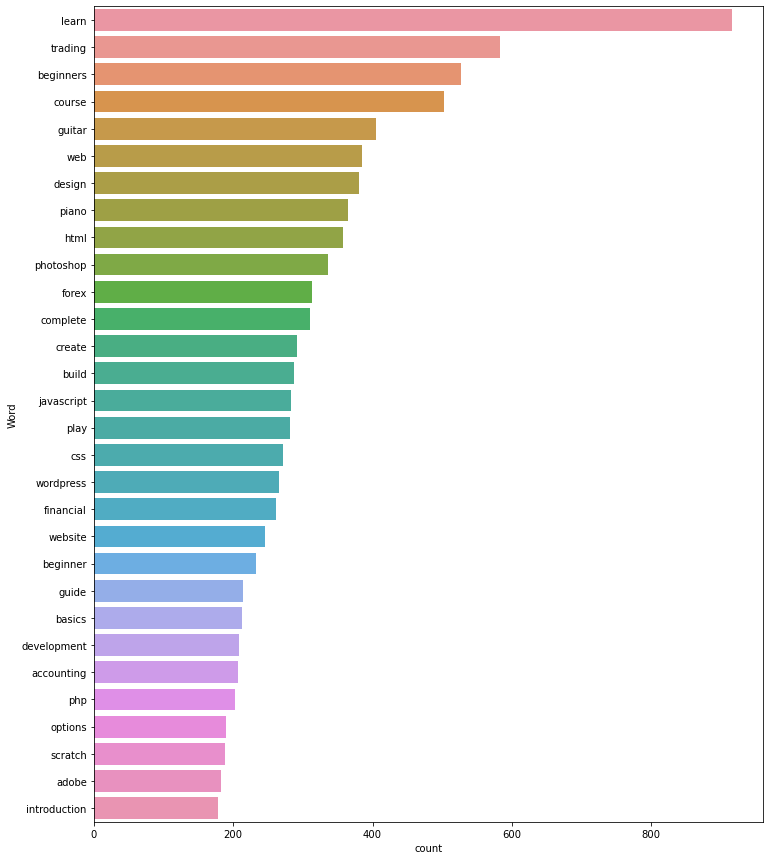

In [19]:
freq_words(dfCursos['clean_course'], 100)

### Convertendo Texto em Características

Usando o OneHotEncode() do sklearn para codificar a variável de destino. Uma vez que existem 4 tags de assunto exclusivas, haverá 4 novas variáveis de destino.

In [20]:
# Instatniate One-Hot-Encoder
ohe = OneHotEncoder(categories = "auto",sparse = False)

# One-Hot-Encode Class column of df
y = ohe.fit_transform(dfCursos[['subject']])

Dividindo os dados em treino (80%) e teste (20%)

In [21]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(dfCursos['clean_course'], y, test_size=0.2, random_state=9)

Usando os resursos do TF-IDF para processar os dados de texto

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)

In [23]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

Construindo um modelo de regressão logística por ser mais rápido para treinar com poucos recursos.

Usando a classe OneVsRestClassifier do sk-learn para resolver como um problema de relev6ancia binária

In [24]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Ajuste do modelo no conjunto de treino

In [25]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

Fazendo a predição no conjunto de validação

In [26]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

Verificando um exemplo de previsão

In [27]:
y_pred[5]

array([0, 0, 0, 0])

Usando a função inverse_transform junto com o OneHotencode para converter a matriz prevista

In [28]:
ohe.inverse_transform(y_pred)[5]

array(['Business Finance'], dtype=object)

Avaliar o desempenho

In [29]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.9049373618275609

Obtivemos uma pontuação decente na F1 de 0,916. Essas previsões foram feitas com base em um valor limite de 0,5, o que significa que as probabilidades maiores ou iguais a 0,5 foram convertidas em 1 e as demais em 0.

Testar outros valores de limites

In [30]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [31]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [32]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.9481582537517053

### Criar função de inferência

Construir uma função de inferência. Ele pegará um curso e seguirá as etapas abaixo:

*   Limpe o texto
*   Remova as palavras irrelevantes do texto limpo
*   Extraia recursos do texto
*   Fazer previsões
*   Retorna as tags subject previstas

In [33]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    r = ohe.inverse_transform(q_pred)
    r = r[0]
    r = r[0]
    return r

Testando alguns exemplos

In [34]:
count = 0
rg = 10
for i in range(rg):
    k = xval.sample(1).index[0]
    print("Course: ", dfCursos['course_title'][k])
    print("Predicted subject: ", infer_tags(xval[k]))
    print("Actual subject: ", dfCursos['subject'][k])  
    if infer_tags(xval[k]) == dfCursos['subject'][k]:
        print("Answer: Right", "\n")
        count = count + 1
    else:
        print("Answer: Wrong", "\n")

print("Total Predictions: ", rg)
print("Correct Predictions: ", count)
print("% Correct: ", (count/rg)*100)

Course:  How to read a Profit & Loss Account and Balance Sheet
Predicted subject:  Business Finance
Actual subject:  Business Finance
Answer: Right 

Course:  Introduction to Piano - By PGN Piano!
Predicted subject:  Musical Instruments
Actual subject:  Musical Instruments
Answer: Right 

Course:  Photoshop & Illustrator CC Essentials in Arabic
Predicted subject:  Graphic Design
Actual subject:  Graphic Design
Answer: Right 

Course:  JavaScript manipulation of the DOM Document Object Model
Predicted subject:  Web Development
Actual subject:  Web Development
Answer: Right 

Course:  Learn  After Effects and master 3d layers in after effects
Predicted subject:  Business Finance
Actual subject:  Graphic Design
Answer: Wrong 

Course:  Learn To Build A Google Map App Using Angular 2
Predicted subject:  Web Development
Actual subject:  Web Development
Answer: Right 

Course:  App Design + Web Design + Photoshop = Combined Course
Predicted subject:  Graphic Design
Actual subject:  Graphic D